In [3]:
import numpy as np
import torch as pt
import torch.nn as nn
import torch.nn.functional as f
import torch.optim as optim
import collections as coll
from mpl_toolkits import mplot3d
import matplotlib.pyplot as plt
from matplotlib import cm
import gc
import numpy as np
import torch as pt
import torch
import torch.nn as nn
import torch

def print_gpu_memory():
    allocated_memory = torch.cuda.memory_allocated() / 1024 ** 3
    cached_memory = torch.cuda.memory_reserved() / 1024 ** 3
    print(f"Allocated GPU Memory: {allocated_memory:.2f} GB")
    print(f"Cached GPU Memory: {cached_memory:.2f} GB")

print_gpu_memory()
import time as TIME
import torch_tensorrt
from FHNCUDAlib import FHNCUDA
import numpy as np

import tensorrt as trt
import pycuda.driver as cuda
import pycuda.autoinit

loaded_module = nn.Linear(10,10)
st=torch.load('network.0.pth')
from torch import nn
import torch.utils.model_zoo as model_zoo
import torch.onnx
import tensorrt as trt
import pycuda.driver as cuda
import pycuda.autoinit


pt.set_grad_enabled (False) 
numinputs=1
numoutputs=2
class Net(nn.Module):
    def __init__(self, numinputs, numoutputs, numlayers=4, H=10):
        super(Net, self).__init__()

        self.layers = nn.ModuleList()
        self.layers.append(nn.utils.weight_norm(nn.Linear(numinputs, H), name='weight', dim=0).cuda())

        for _ in range(numlayers - 1):
            self.layers.append(nn.utils.weight_norm(nn.Linear(H, H), name='weight', dim=0).cuda())

        self.final_layer = nn.Linear(H, numoutputs).cuda()

        for layer in self.layers:
            layer.eval()
        self.final_layer.eval()

    def forward(self, x):
        for layer in self.layers:
            x = f.silu(layer(x))

        return self.final_layer(x)

    def load(self, od):
        for k, v in od.items():
            if k.startswith('_impl.layers'):
                layer_num = int(k.split('.')[2])
                layer = self.layers[layer_num]
                if k.endswith('linear.weight'):
                    layer.weight_v.data = v
                    layer.weight_v.requires_grad = False
                elif k.endswith('linear.weight_g'):
                    layer.weight_g.data = v
                    layer.weight_g.requires_grad = False
                elif k.endswith('linear.bias'):
                    layer.bias.data = v
                    layer.bias.requires_grad = False
            elif k == '_impl.final_layer.linear.weight':
                self.final_layer.weight.data = v
                self.final_layer.weight.requires_grad = False
            elif k == '_impl.final_layer.linear.bias':
                self.final_layer.bias.data = v
                self.final_layer.bias.requires_grad = False

    def __prepare_scriptable__(self):
        for layer in self.layers:
            for hook in layer._forward_pre_hooks.values():
                if hook.__module__ == "torch.nn.utils.weight_norm" and hook.__class__.__name__ == "WeightNorm":
                    torch.nn.utils.remove_weight_norm(layer)
        return self

import itertools



def Modelrun_s(x,M):
   
    gc.collect()
    torch.cuda.empty_cache()
    my2dspace = pt.tensor(x, requires_grad=False).float().cuda()
    M.eval()
    start_time = TIME.time()
    myOutput = M(my2dspace)
    torch.cuda.synchronize()  # Wait for the events to be recorded!
    reftime = TIME.time()- start_time
    myCPUOutput = myOutput.cpu()


    uu = myCPUOutput.numpy()

    #print('uu: ', uu.T[0])

    myCPUOutput.squeeze().detach().numpy()
    gc.collect()
    torch.cuda.empty_cache()
    return uu,reftime


def Modelrun(x, M, batch_size=10*20*10*200):

    my2dspace = x
    M.eval()
        
    num_samples = my2dspace.shape[0]
  
    gc.collect()
    torch.cuda.empty_cache()
    uu_list = []
   

    reftime =0
    
    gc.collect()
    torch.cuda.empty_cache()
    print("batchs ",num_samples//batch_size)

    for i in range(0, num_samples, batch_size):

        
        
        
        #print_gpu_memory()

        batch_input =torch.tensor(my2dspace[i:i+batch_size], requires_grad=False).float().cuda() 
        
        
       # print_gpu_memory()

        
        
        start_time = TIME.time()
        

        batch_output = M(batch_input)
        
        
 

        torch.cuda.synchronize()  # Wait for the events to be recorded!
        
        
        
        
        reftime =reftime+ TIME.time() - start_time
        
        
        uu_list.append(batch_output.cpu().numpy())
        #del batch_input
        #del batch_output
        #print_gpu_memory()
       
 
    uu = np.concatenate(uu_list)
    
    return uu, reftime


def compileRT(modelTorch):
    gc.collect()
    torch.cuda.empty_cache()
    X=np.zeros((2,5))
    model = torch.jit.script(modelTorch).eval()  # torch module needs to be in eval (not training) mode



    trt_ts_module = torch_tensorrt.compile(modelTorch, inputs = [torch_tensorrt.Input(
            min_shape=(1*100,4),
            opt_shape=(10*1024*100,4),
        
            max_shape=(40000*100,4),
            dtype=torch.float32)],
        enabled_precisions = torch.float16, # Run with FP32
        #workspace size referece a quantidade de memoria usado na build phase, removi para alocar toda a memoria do device, deve acelerar o processo
    )


    gc.collect()
    torch.cuda.empty_cache()
    return trt_ts_module


print("Compiling")
net =Net(4,2,6,32)


PATH=""
od=pt.load('network.0.pth')
net.load(od)
net=net.cuda()


model =  compileRT(net)
print("Done compiling")

print("Memory",print_gpu_memory())

# The flag below controls whether to allow TF32 on matmul. This flag defaults to False
# in PyTorch 1.12 and later.
print(torch.backends.cuda.matmul.allow_tf32)
#F32 on cuDNN. This flag defaults to True.
print(torch.backends.cudnn.allow_tf32)
print(net)




batch_size=batch_size=1024*100
x=torch.rand((batch_size,4)).cuda()
# Export the model
torch.onnx.export(net,               # model being run
                  x,                         # model input (or a tuple for multiple inputs)
                  "model.onnx",   # where to save the model (can be a file or file-like object)
                 # export_params=True,        # store the trained parameter weights inside the model file
                  opset_version=10,          # the ONNX version to export the model to
                 # do_constant_folding=True,  # whether to execute constant folding for optimization
           )




!/opt/tensorrt/bin/trtexec  --onnx=model.onnx --saveEngine=model.trt  --explicitBatch --useSpinWait


Allocated GPU Memory: 0.00 GB
Cached GPU Memory: 0.00 GB
Compiling


Done compiling
Allocated GPU Memory: 0.00 GB
Cached GPU Memory: 0.00 GB
Memory None
True
True
Net(
  (layers): ModuleList(
    (0): Linear(in_features=4, out_features=32, bias=True)
    (1-5): 5 x Linear(in_features=32, out_features=32, bias=True)
  )
  (final_layer): Linear(in_features=32, out_features=2, bias=True)
)
=========== Diagnostic Run torch.onnx.export version 2.1.0a0+4136153 ===========
verbose: False, log level: Level.ERROR
======================= 0 NONE 0 NOTE 0 WARNING 0 ERROR ========================

&&&& RUNNING TensorRT.trtexec [TensorRT v8601] # /opt/tensorrt/bin/trtexec --onnx=model.onnx --saveEngine=model.trt --explicitBatch --useSpinWait
[11/05/2023-01:46:47] [W] --explicitBatch flag has been deprecated and has no effect!
[11/05/2023-01:46:47] [W] Explicit batch dim is automatically enabled if input model is ONNX or if dynamic shapes are provided when the engine is built.
[11/05/2023-01:46:47] [I] === Model Options ===
[11/05/2023-01:46:47] [I] Format: ONNX
[11/0

In [4]:
%%time


f = open("model.trt", "rb")

runtime = trt.Runtime(trt.Logger(trt.Logger.WARNING)) 

engine = runtime.deserialize_cuda_engine(f.read())
context = engine.create_execution_context()


def modelRT(samples,batch_size):
    num_samples=len(samples)
    print("batches ",num_samples//batch_size)
    reftime=0   
    R=np.zeros((num_samples,2))
    for i in range(0, num_samples, batch_size):
        #print("batch ",i)
        
        batch=np.array(samples[i:i+batch_size],dtype=np.float32)#np.array(samples[i:i+batch_size],dtype=np.float32).T
        #print((batch))
        #print(num_samples)
        # need to set input and output precisions to FP16 to fully enable it
        output = np.empty([batch_size, 2], dtype = np.float32) 
        #print(np.shape(output))
        # allocate device memory
        #print(batch.nbytes,output.nbytes)
        d_output = cuda.mem_alloc(1 * output.nbytes)
        d_input = cuda.mem_alloc(1 * batch.nbytes)
        bindings = [int(d_input), int(d_output)]

        stream = cuda.Stream()
        
        if(True): # result gets copied into output
            # transfer input data to device

            cuda.memcpy_htod_async(d_input, batch, stream)

            # execute model
            start_time = TIME.time()
        

        
 

    
            context.execute_async_v2(bindings, stream.handle, None)
        
        

            
            stream.synchronize()
            reftime =reftime+ TIME.time() - start_time
            # transfer predictions back
            cuda.memcpy_dtoh_async(output, d_output, stream)
            # syncronize threads
            stream.synchronize()
            #print(np.shape(output))
            #plt.plot(output.T[0][100:])
            #plt.show()
        if(i+batch_size<num_samples):

            R[i:i+batch_size,:]=output
        else:
            R[i:num_samples]=output[:num_samples-i]

    return np.array(R),reftime

 

CPU times: user 1.12 ms, sys: 9.26 ms, total: 10.4 ms
Wall time: 51.5 ms


In [5]:
#!pip install --upgrade tensorrt
import tensorrt as trt
import os
print(trt.__version__)
assert trt.Builder(trt.Logger())

8.6.1


AttributeError: module 'pycuda.driver' has no attribute 'synchronize'

Allocated GPU Memory: 0.01 GB
Cached GPU Memory: 0.04 GB
[[0.005  0.004  0.08  ]
 [0.005  0.004  0.0803]
 [0.005  0.004  0.0806]
 ...
 [0.995  0.0976 0.0851]
 [0.995  0.0976 0.0854]
 [0.995  0.0976 0.0857]]
(80000, 3)
kernel call: ./a.out 50 0.01 50
35
Number of rows in the CSV file:  80000 100
-------------------------CUDA ----------------------------
kernel call: ./a.out 50 0.01 50
35
Number of rows in the CSV file:  80000 100
Shape cudapred  (80000, 100)
cuda time [0.00036364800000000005, 0.036220322000000006, 2.294156982]
Error Calculation
mean 0.0
max 0.0


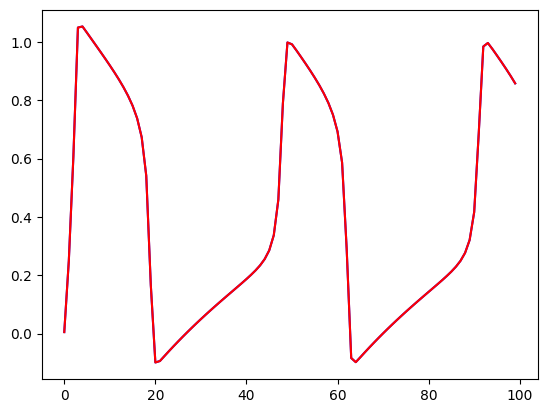

(100,)
[ 0.   0.5  1.   1.5  2.   2.5  3.   3.5  4.   4.5  5.   5.5  6.   6.5
  7.   7.5  8.   8.5  9.   9.5 10.  10.5 11.  11.5 12.  12.5 13.  13.5
 14.  14.5 15.  15.5 16.  16.5 17.  17.5 18.  18.5 19.  19.5 20.  20.5
 21.  21.5 22.  22.5 23.  23.5 24.  24.5 25.  25.5 26.  26.5 27.  27.5
 28.  28.5 29.  29.5 30.  30.5 31.  31.5 32.  32.5 33.  33.5 34.  34.5
 35.  35.5 36.  36.5 37.  37.5 38.  38.5 39.  39.5 40.  40.5 41.  41.5
 42.  42.5 43.  43.5 44.  44.5 45.  45.5 46.  46.5 47.  47.5 48.  48.5
 49.  49.5]
Allocated GPU Memory: 0.01 GB
Cached GPU Memory: 0.04 GB


In [19]:

print_gpu_memory()
from itertools import product
torch.cuda.empty_cache()
krange = [(0.08 + 0.003 * i * 0.1) for i in range(0, 20)]
vrange = [(0.004 + 0.02 * i * 0.12) for i in range(0, 40)]
urange = [(0.005 + 0.01 * i * 1) for i in range(0, 100)]


param_list = np.array(list(product(urange,vrange, krange )))




x0=np.array(param_list)

print(x0)

print(np.shape(x0))
dt,tt=0.01,50

rate=50


##Cuda ref
start_time = TIME.time()
u,v ,t,p=FHNCUDA.run(x0,tt,dt,rate)
reftime = TIME.time()- start_time
p=[i/1000 for i in p[0]]
u_ref=np.array(u).flatten()




print("-------------------------CUDA ----------------------------")

###Cuda run
start_time = TIME.time()
u,v ,t,p=FHNCUDA.run(x0,tt,dt,rate)
cudatime = TIME.time()- start_time

u_num=np.array(u).flatten()
print("Shape cudapred ",np.shape(u))

#print(np.unique(t))
p=[i/1000 for i in p[0]]
print("cuda time",p)
print("Error Calculation")
e=((u_ref-u_num)**2)**(1/2)
print("mean",np.mean(e))
m=np.max(e)
print("max",m)
plt.plot(u_ref[:100],"b")
plt.plot(u_num[:100],"r")

plt.show()

t=np.array(t).flatten()
print(np.shape(t))

print(t)
param_list = []

for u in urange:
    for v in vrange:
            for k in krange:
                for T in t:
                    param_list.append([T,u,v,k])





x0=np.array(param_list)
#print(x0)
#print(x0)
print_gpu_memory()

In [2]:
##PRED NETWORK RT
print("-------------------------TENSOR RT ----------------------------")
print(np.shape(t))
batch_size=1024*100
start_time = TIME.time()
for _ in range (3):
    u,net_time=modelRT(x0,batch_size)#Modelrun(x0,M=model,batch_size=bs)
    print("Warm up",net_time)

for _ in range (1):
    u,net_time= u,net_time=modelRT(x0,batch_size)#Modelrun(x0,M=model,batch_size=bs)
    
    
u_net=u.T[0].flatten()
print("Shape netpred ",np.shape(u_net))
print("net time", net_time/1)
print("Error Calculation")
e=((u_ref-u_net)**2)**(1/2)
print("mean",np.mean(e))
m=np.max(e)
print("max",m)
i=[a for a in range(len(e)) if e[a]==m]


plt.plot(u_ref[100:9*100],"b")
plt.plot(u_net[100:9*100],"r")
plt.show()
print("-----------------------------------------------------")





-------------------------TENSOR RT ----------------------------


NameError: name 'np' is not defined

In [1]:
bs=batch_size
##PRED NETWORK RT
print("-------------------------TENSOR RT ----------------------------")
print(np.shape(t))
start_time = TIME.time()
for _ in range (3):
    u,net_time=Modelrun(x0,M=model,batch_size=batch_size)
    print("Warm up",net_time)

for _ in range (1):
    u,net_time=Modelrun(x0,M=model,batch_size=batch_size)
    
    
u_net=u.T[0].flatten()
print("Shape netpred ",np.shape(u_net))
print("net time", net_time/1)
print("Error Calculation")
e=((u_ref-u_net)**2)**(1/2)
print("mean",np.mean(e))
m=np.max(e)
print("max",m)
i=[a for a in range(len(e)) if e[a]==m]


plt.plot(u_ref[100:9*100],"b")
plt.plot(u_net[100:9*100],"r")
plt.show()
print("-----------------------------------------------------")


gc.collect()
torch.cuda.empty_cache()

print_gpu_memory()

print_gpu_memory()
##PRED NETWORK TORCH
print("-------------------------TORCH ----------------------------")
print(np.shape(t))
start_time = TIME.time()
for _ in range (3):
    u,net_time=Modelrun(x0,M=net,batch_size=200*bs)
    print("warm up  time",net_time)


for _ in range (1):
    u,net_time=Modelrun(x0,M=net,batch_size=200*bs)

print(np.shape(u))
u_net=u.T[0].flatten()

print("Shape netpred ",np.shape(u_net))
print("net time", net_time/1)
print("Error Calculation")
e=((u_ref-u_net)**2)**(1/2)
print("mean",np.mean(e))
m=np.max(e)
print("max",m)
i=[a for a in range(len(e)) if e[a]==m]


plt.plot(u_ref[0:1000],"b")
plt.plot(u_net[0:1000],"r")

plt.legend(loc="best")

plt.show()
("-----------------------------------------------------")


print_gpu_memory()
#PRED NETWORK JIT
print("-------------------------JIT ----------------------------")

print(np.shape(t))
start_time = TIME.time()
for _ in range (1):
    u,net_time=Modelrun(x0,M=torch.jit.script(net).cuda(),batch_size=200*bs)
u_net=u.T[0].flatten()
print("Shape netpred ",np.shape(u_net))
print("net time", net_time/1)
print("Error Calculation")
e=((u_ref-u_net)**2)**(1/2)
print("mean",np.mean(e))
m=np.max(e)
print("max",m)
i=[a for a in range(len(e)) if e[a]==m]


plt.plot(u_ref[0:1000],"b")
plt.plot(u_net[0:1000],"r")
plt.show()
print("-----------------------------------------------------")

print_gpu_memory()

NameError: name 'batch_size' is not defined

del batch_input

In [ ]:
gc.collect()
torch.cuda.empty_cache()
print_gpu_memory()


In [ ]:
!scalene v.py

In [ ]:
def d(f):
    bs=1024*(f)

    ##PRED NETWORK RT
    print("-------------------------TENSOR RT ----------------------------")
    print(np.shape(t))
    start_time = TIME.time()

    
    net_time=0
    for _ in range (5):
        u,nt=Modelrun(x0,M=model,batch_size=bs)
        net_time=net_time+nt

    u_net=u.T[0].flatten()
    print("Shape netpred ",np.shape(u_net))
    print("net time", net_time/5)
    print("Error Calculation")
    e=((u_ref-u_net)**2)**(1/2)
    print("mean",np.mean(e))
    m=np.max(e)
    print("max",m)
    i=[a for a in range(len(e)) if e[a]==m]

    print("-----------------------------------------------------")
    return bs,net_time

for _ in range (1):
        u,net_time=Modelrun(x0,M=model,batch_size=10000*100)
        print("Warm up",net_time)

factors=[25,50,75,100,200,300,400,500,1000]
res=[]
x=[]

for f in factors:
        xx,y=d(f)
        print(xx,y)
        res.append(y)
        x.append(xx)
plt.plot(x,res)
plt.show()

In [ ]:
print(x)

In [ ]:
plt.plot(factors,res)
plt.show()